---
date: last-modified
---

# Demonstration for working with TEMPO data via `earthaccess`

## Overview

This notebook retrieves TEMPO data, inspects characteristics of the data such as array shapes and quality flags, and then creates a visualization of total column nitrogen dioxide concentrations.

## Dataset Information

This notebook uses data from the [Tropospheric Emissions: Monitoring of Pollution (TEMPO)](https://asdc.larc.nasa.gov/project/TEMPO) instrument.

## Table of Contents

1. Setup
2. Search for data granules
3. Examining and downloading file results
4. Reading and inspecting the data
5. Working with the data to subset and plot
6. Using Harmony-py to pre-process and retrieve data
7. Plotting the data

## Prerequisites

A free(!) account at https://www.earthdata.nasa.gov/ is needed to login and download the appropriate files.

### Notebook Author / Affiliation

Alexander Radkevich / Atmospheric Science Data Center (ASDC)

# 1. Setup

In [1]:
import earthaccess  # needed to discover and download TEMPO data
import netCDF4 as nc  # needed to read TEMPO data
import numpy as np

import matplotlib.pyplot as plt  # needed to plot the resulting time series
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 2. Establish access to EarthData - Log in

If credentials are not already stored, `earthaccess.login` will prompt for EarthData login and password.

In [2]:
auth = earthaccess.login(persist=True)

# 3. Search for TEMPO granules

First, we specify the data collection by name, a Point of Interest (POI), and a temporal range.

In [3]:
short_name = "TEMPO_NO2_L3"  # collection name to search for in the EarthData
version = "V03"

# Point of interest: NASA Langley Research Center, HamptonVA, USA
# latitude 37.1036 deg, longitude -76.3868 deg
# POI_lat = 37.1036
# POI_lon = -76.3868

# generic location, somewhere in the middle of the USA
POI_lat = 38.0
POI_lon = -96.0
date_start = "2024-09-01 00:00:00"
date_end = "2024-09-01 23:59:59"

Now we search for nitrogen dioxide ($NO_2$) data granules from TEMPO.

In [6]:
POI_results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    temporal=(date_start, date_end),
    point=(POI_lon, POI_lat),  # search by point of interest
)

print(len(POI_results))

18


In [7]:
dlat = 5.0  # deg
dlon = 6.0  # deg

bbox_results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    temporal=(date_start, date_end),
    bounding_box=(
        POI_lon - dlon,
        POI_lat - dlat,
        POI_lon + dlon,
        POI_lat + dlat,
    ),  # search by bounding box
)

print(len(bbox_results))

18


# 4. Examine and download file results

## What does a result look like?

In [8]:
POI_results[0]

Collection: {'ShortName': 'TEMPO_NO2_L3', 'Version': 'V03'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 57.02, 'Longitude': -163.84}, {'Latitude': 56.94, 'Longitude': -163.72}, {'Latitude': 56.1, 'Longitude': -158.9}, {'Latitude': 55.08, 'Longitude': -154.7}, {'Latitude': 53.88, 'Longitude': -150.84}, {'Latitude': 52.4, 'Longitude': -147.02}, {'Latitude': 50.66, 'Longitude': -143.38}, {'Latitude': 48.7, 'Longitude': -140.02}, {'Latitude': 46.62, 'Longitude': -137.06}, {'Latitude': 44.1, 'Longitude': -134.08}, {'Latitude': 41.38, 'Longitude': -131.42}, {'Latitude': 38.42, 'Longitude': -129.02}, {'Latitude': 35.62, 'Longitude': -127.12}, {'Latitude': 32.42, 'Longitude': -125.3}, {'Latitude': 29.02, 'Longitude': -123.7}, {'Latitude': 25.44, 'Longitude': -122.32}, {'Latitude': 21.64, 'Longitude': -121.14}, {'Latitude': 17.56, 'Longitude': -120.14}, {'Latitude': 17.26, 'Longitude': -102.38}, {'Latitude': 17.22, 'Longitude': -83.74001}, {'Latitude': 29.44, 'Longitude': -82.82}, {'Latitude': 34.42, 'Longitude': -82.28}, {'Latitude': 40.04, 'Longitude': -81.5}, {'Latitude': 48.12, 'Longitude': -79.92}, {'Latitude': 52.84, 'Longitude': -78.62}, {'Latitude': 57.3, 'Longitude': -77}, {'Latitude': 57.92, 'Longitude': -77}, {'Latitude': 57.76, 'Longitude': -81.08}, {'Latitude': 57.64, 'Longitude': -86.98}, {'Latitude': 57.68, 'Longitude': -96.62}, {'Latitude': 58, 'Longitude': -106.2}, {'Latitude': 58.56, 'Longitude': -115.46}, {'Latitude': 59.48, 'Longitude': -126.08}, {'Latitude': 60.6, 'Longitude': -136.36}, {'Latitude': 62.08, 'Longitude': -147.78}, {'Latitude': 63.76, 'Longitude': -159.66}, {'Latitude': 63.6, 'Longitude': -159.68}, {'Latitude': 63.76, 'Longitude': -160.82}, {'Latitude': 62.04, 'Longitude': -160.96}, {'Latitude': 62.06, 'Longitude': -161.12}, {'Latitude': 61.96, 'Longitude': -161.14}, {'Latitude': 61.98, 'Longitude': -161.36}, {'Latitude': 61.88, 'Longitude': -161.38}, {'Latitude': 61.94, 'Longitude': -161.84}, {'Latitude': 60.58, 'Longitude': -162.06}, {'Latitude': 60.66, 'Longitude': -162.78}, {'Latitude': 59.58, 'Longitude': -162.8}, {'Latitude': 59.6, 'Longitude': -162.94}, {'Latitude': 58.2, 'Longitude': -163.1}, {'Latitude': 58.28, 'Longitude': -163.76}, {'Latitude': 57.96, 'Longitude': -163.84}, {'Latitude': 57.02, 'Longitude': -163.84}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-08-31T23:58:44+00:00', 'EndingDateTime': '2024-09-01T00:38:30+00:00'}}
Size(MB): 534.3889923095703
Data: ['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L3_V03/2024.08.31/TEMPO_NO2_L3_V03_20240831T235844Z_S016.nc']

Let's get the link to a granule (`-1` to index the last granule in the results).

In [9]:
print(POI_results[-1].data_links()[0])

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L3_V03/2024.09.01/TEMPO_NO2_L3_V03_20240901T235825Z_S016.nc


Let's examine the file names present in the results object.

In [10]:
for r in POI_results:
    granule_name = r.data_links()[0].split("/")[-1]
    print(granule_name)

TEMPO_NO2_L3_V03_20240831T235844Z_S016.nc
TEMPO_NO2_L3_V03_20240901T003849Z_S017.nc
TEMPO_NO2_L3_V03_20240901T105755Z_S001.nc
TEMPO_NO2_L3_V03_20240901T113800Z_S002.nc
TEMPO_NO2_L3_V03_20240901T121805Z_S003.nc
TEMPO_NO2_L3_V03_20240901T125810Z_S004.nc
TEMPO_NO2_L3_V03_20240901T133815Z_S005.nc
TEMPO_NO2_L3_V03_20240901T143815Z_S006.nc
TEMPO_NO2_L3_V03_20240901T153815Z_S007.nc
TEMPO_NO2_L3_V03_20240901T163815Z_S008.nc
TEMPO_NO2_L3_V03_20240901T173815Z_S009.nc
TEMPO_NO2_L3_V03_20240901T183815Z_S010.nc
TEMPO_NO2_L3_V03_20240901T193815Z_S011.nc
TEMPO_NO2_L3_V03_20240901T203815Z_S012.nc
TEMPO_NO2_L3_V03_20240901T213815Z_S013.nc
TEMPO_NO2_L3_V03_20240901T223815Z_S014.nc
TEMPO_NO2_L3_V03_20240901T231820Z_S015.nc
TEMPO_NO2_L3_V03_20240901T235825Z_S016.nc


## Downloading granules

Here we'll download two of the files.

In [11]:
files = earthaccess.download(POI_results[8:10], local_path=".")

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

# 5. Reading and inspecting the data

We first define a function for reading data from TEMPO_NO2_L3_V03 netCDF file.

In [12]:
def read_TEMPO_NO2_L3(fn):
    with nc.Dataset(fn) as ds:  # open read access to file
        # Open the 'product' group.
        prod = ds.groups["product"]

        # Read variable vertical_column_stratosphere from the product group.
        var = prod.variables["vertical_column_stratosphere"]
        strat_NO2_column = var[:]  # retrieve the numpy array.
        fv_strat_NO2 = var.getncattr("_FillValue")

        # Read variable 'vertical_column_troposphere' from the product group.
        var = prod.variables["vertical_column_troposphere"]
        trop_NO2_column = var[:]
        fv_trop_NO2 = var.getncattr("_FillValue")
        NO2_unit = var.getncattr("units")

        # Read variable 'main_data_quality_flag' from the product group.
        QF = prod.variables["main_data_quality_flag"][:]

        # Read latitude and longitude variables, from the root (/) group, into a numpy array.
        lat = ds.variables["latitude"][:]
        lon = ds.variables["longitude"][:]

    return lat, lon, strat_NO2_column, fv_strat_NO2, trop_NO2_column, fv_trop_NO2, NO2_unit, QF

### Let's now examine the data in a granulue

In [16]:
granule_name = POI_results[8].data_links()[0].split("/")[-1]
print(granule_name)

lat, lon, strat_NO2_column, fv_strat_NO2, trop_NO2_column, fv_trop_NO2, NO2_unit, QF = (
    read_TEMPO_NO2_L3(granule_name)
)

TEMPO_NO2_L3_V03_20240901T153815Z_S007.nc


In [17]:
print("unit of NO2 column is ", NO2_unit)  # unit of NO2 column

unit of NO2 column is  molecules/cm^2


In [18]:
# lat is a 1D array:
lat.shape

(2950,)

In [19]:
# lat is a 1D array:
lon.shape

(7750,)

In [20]:
# stratospheric NO2 column is a 3D array
# with second dimension being the number of latitudes and third being the number of longitudes:
strat_NO2_column.shape

(1, 2950, 7750)

In [21]:
# and so is tropospheric NO2 column:
trop_NO2_column.shape

(1, 2950, 7750)

### Finding 'good' pixels

What is the fill value for the array of stratospheric NO2 column?

In [27]:
fv_strat_NO2

np.float64(-1e+30)

How many valid (non-fill) values are there?

In [24]:
len(strat_NO2_column[strat_NO2_column != fv_strat_NO2])

22862500

In [25]:
len(trop_NO2_column[trop_NO2_column != fv_trop_NO2])

22862500

How many pixels with high quality flag, 0, are there?

In [26]:
len(QF[QF == 0])

7363629

Notice that the number of non-fill values and high-quality values are different.

**So, we need to create arrays of equal length to combine them to get total column.**

In [28]:
good_data_mask = (QF == 0) & (trop_NO2_column != fv_trop_NO2) & (strat_NO2_column != fv_strat_NO2)
print(good_data_mask.shape)

(1, 2950, 7750)


How many good pixels are there?

In [29]:
good_trop_NO2_column = trop_NO2_column[good_data_mask]
len(good_trop_NO2_column)

7363629

Unfortunate reality - "good" pixels may contain negative column.

In [30]:
min(good_trop_NO2_column)

np.float64(-5.4297665877187496e+16)

**Getting physically meaningful pixels**

In [31]:
best_data_mask = good_data_mask & (trop_NO2_column > 0.0) & (strat_NO2_column > 0.0)

In [32]:
best_trop_NO2_column = trop_NO2_column[best_data_mask]
len(best_trop_NO2_column)

6262529

# 6. Working with the data to subset and plot

### Spatial subsetting and masking out bad data

In [33]:
# Define a region of interest.
dlat = 5  # deg
dlon = 6  # deg
mask_lat = (lat > POI_lat - dlat) & (lat < POI_lat + dlat)
mask_lon = (lon > POI_lon - dlon) & (lon < POI_lon + dlon)

# Subset NO2 column arrays.
trop_NO2_column_loc = trop_NO2_column[0, mask_lat, :][:, mask_lon]
strat_NO2_column_loc = strat_NO2_column[0, mask_lat, :][:, mask_lon]
QF_loc = QF[0, mask_lat, :][:, mask_lon]
best_data_mask_loc = (QF_loc == 0) & (trop_NO2_column_loc > 0.0) & (strat_NO2_column_loc > 0.0)

# Create 2D arrays of latitudes and longitudes, by repeating lon/lat along rows/columns.
nlat, nlon = trop_NO2_column_loc.shape
lon_loc_2D = np.vstack([lon[mask_lon]] * nlat)
lat_loc_2D = np.column_stack([lat[mask_lat]] * nlon)

### Plotting spatial distribution

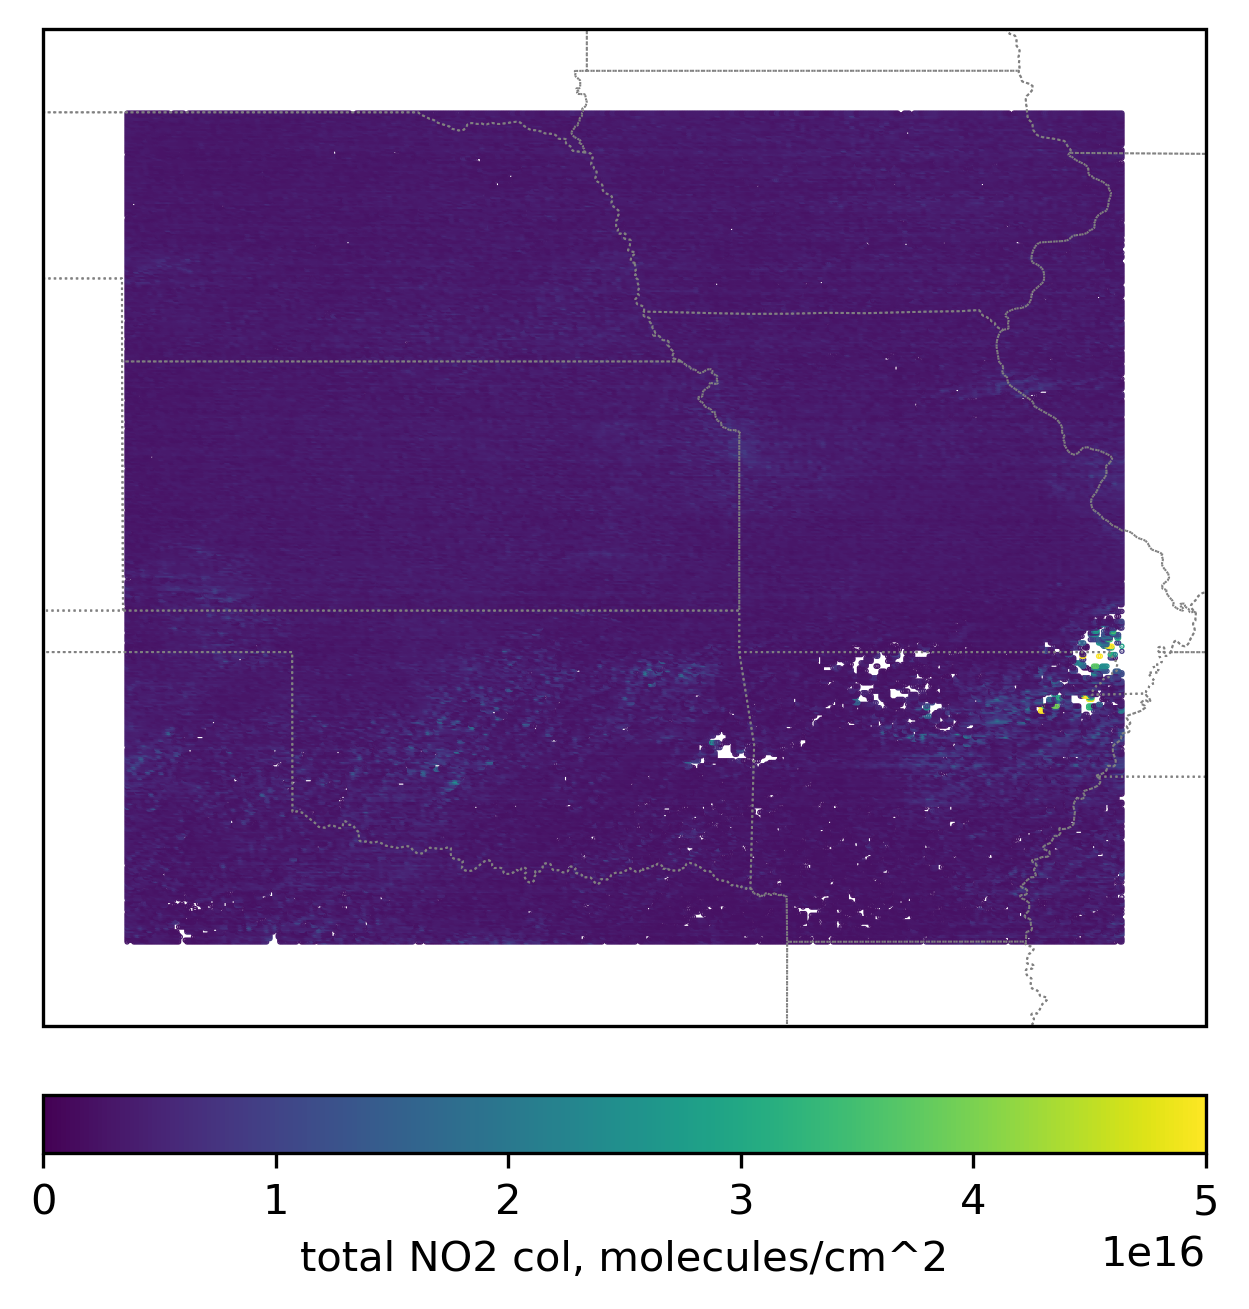

In [44]:
# Create a Cartopy projection
proj = ccrs.PlateCarree()
transform = ccrs.PlateCarree()

# Create a figure and axis.
fig, ax = plt.subplots(
    1, 1, figsize=(5, 6), dpi=300, facecolor=None, subplot_kw={"projection": proj}
)

# Add coastlines and U.S. state borders
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="gray", linewidth=0.5)

im = ax.scatter(
    lon_loc_2D[best_data_mask_loc],
    lat_loc_2D[best_data_mask_loc],
    s=0.1,
    c=trop_NO2_column_loc[best_data_mask_loc] + strat_NO2_column_loc[best_data_mask_loc],
    vmin=0,
    vmax=5.0e16,
    transform=transform,
)
ax.set_extent([-103, -89, 32, 44], crs=transform)

cb = plt.colorbar(
    im,
    ticks=[0, 1.0e16, 2.0e16, 3.0e16, 4.0e16, 5.0e16],
    location="bottom",
    fraction=0.05,
    pad=0.05,
)
cb.set_label("total NO2 col, " + NO2_unit, fontsize=10)

plt.show()